# Задание 2. Регрессия

---


## Этапы:
1. Генерация данных (линейная комбинация признаков + шум)
2. Разделение на train/test
3. Построение модели (Bagging + LinearRegression)
4. Оценка по MSE и R²
5. Проверка мультиколлинеарности (корреляции, VIF)
6. Анализ остатков
7. Оценка важности признаков

---


### 1. Генерация данных

In [27]:
import numpy as np

n_samples = 1000
n_features = 10
coefficients = np.random.randn(n_features)

x = np.random.randn(n_samples, n_features)
y = x.dot(coefficients) + np.random.normal(scale=1.0, size=n_samples)  # Добавляем шум

---

### 2. Разделение данных (train 80/ test 20)

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=12)

---

### 3. Построение модели с использованием bagging

In [29]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

bag = BaggingRegressor(estimator=LinearRegression(), n_estimators=100, random_state=12)

---

### 4. Оценка качества модели с помощью метрик MSE (Mean Squared Error) и R^2 (коэффициент детерминации)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

bag.fit(x_train, y_train)
y_pred = bag.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE: %.3f' % mse)  # MSE~1(scale)
print('R2: %.3f' % r2)  # R2 ~ 0.9-0.95

MSE: 0.980
R2: 0.909


In [31]:
import pandas as pd

# Сохраняем результат
pd.DataFrame([{'MSE': mse, 'R2': r2}]).to_csv('../data/regression_metrics.csv', index=False)

### 5. Проверка мультиколлинеарности (корреляции, VIF)

In [32]:
# Корреляция
df_features = pd.DataFrame(x, columns=[f"x{i + 1}" for i in range(n_features)])
corr = df_features.corr()
display(corr.iloc[:5, :5])

,x1,x2,x3,x4,x5
x1,1.000000,-0.056431,0.000131,-0.020459,0.028658
x2,-0.056431,1.000000,0.003991,0.018714,-0.072356
x3,0.000131,0.003991,1.000000,0.032295,-0.002865
x4,-0.020459,0.018714,0.032295,1.000000,-0.007321
x5,0.028658,-0.072356,-0.002865,-0.007321,1.000000


In [33]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame({'features': df_features.columns,
                         'VIF': [variance_inflation_factor(df_features.values, i) for i in range(n_features)]})

display(vif_data)
vif_data.to_csv('../data/regression_vif_data.csv', index=False)

,features,VIF
0,x1,1.007193
1,x2,1.018261
2,x3,1.003062
3,x4,1.007466
4,x5,1.007775
5,x6,1.009881
6,x7,1.006845
7,x8,1.003705
8,x9,1.008637
9,x10,1.005212


Вывод: мультиколлинеарности нет. Признаки в VIF не дублируются, стремятся к 1. В корреляции значения < 0.1, что дает понять о слабой зависимости

---


### 6. Анализ остатков модели

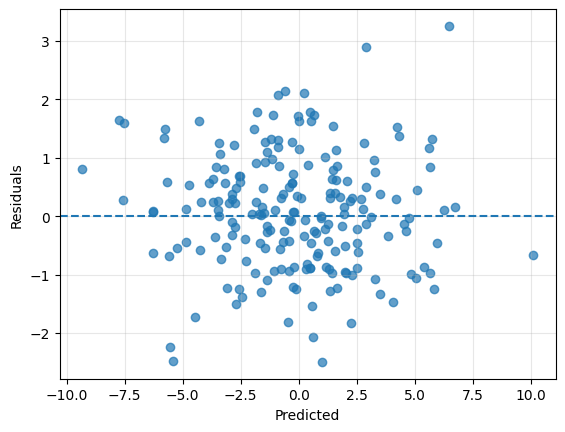

In [34]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Должна быть случайность + близко к 0

---

### 7. Оценка важности признаков

In [35]:
if hasattr(bag, "estimator_"):
    coefs = np.array([est.coef_ for est in bag.estimators_ if hasattr(est, 'coef_')])
    mean_coefs = coefs.mean(axis=0)
    features = pd.DataFrame({
        'feature': df_features.columns,
        'mean_coef': mean_coefs,
        'abs_mean_coef': np.abs(mean_coefs),
    }).sort_values('abs_mean_coef', ascending=False).reset_index(drop=True)
    display(features)
else:
    print("Нет нужного атрибута")


,feature,mean_coef,abs_mean_coef
0,x9,-2.304860,2.304860
1,x5,1.033938,1.033938
2,x2,-1.024329,1.024329
3,x1,-0.825051,0.825051
4,x4,0.810869,0.810869
5,x10,-0.557109,0.557109
6,x3,0.273416,0.273416
7,x8,-0.203568,0.203568
8,x6,0.195464,0.195464
9,x7,0.156782,0.156782
